In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
np.random.seed(42)

In [2]:
# сейвим картинки
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "exitimg"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# игнорим минорные ворнинги SciPy
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

**Задача "Модератор Одноклассников"**
Формулировка задания

В социальной сети Одноклассники есть платформа для разметки данных. На ней пользователям была дана задача выделить прямоугольником заданный объект на фотографии. По ответам людей нужно восстановить истинное положение объекта.

На входе вы получите краудсорсинговую разметку и данные в виде любимых всеми табличек, бейзлайн и тестовый сабмит с нулями. 

В ответ вы должны будете прислать просто файл (такой же, как и sample_submit) с вашими предсказаниями.

Предварительные результаты валидируются на 50% выборки. В день можно загружать не более 5 решений.

Для оценки решения будет использоваться метрика mIOU (mean intersection over union). Если еще не сталкивались с данной метрикой, то рекомендуем прочитать о ней статью.

**Расписание**

Чемпионат будет идти в онлайн формате. Стартуем 27 июня в 19:00, закрываем сабмиты 29 июля в 12:00. Итоги подводим тоже 29 июля в 13:00.

Подарки

1 место: MacBook Pro 13', 2-ядерный процессор, 256 GB SSD, 16 RAM.
2 место: iPhone XS Max, 256 GB.
3 — 6 место: Apple Watch Series 3 42mm или Samsung Gear S3 Frontier на выбор.
7 — 10 место: Western Digital My Passport 4 TB.

Топ-30% пользователей от всего количества участников получат футболки.

In [3]:
def area(box):
    return (box[2] - box[0]) * (box[3] - box[1])


def intersection_over_union(boxes):
    assert(len(boxes) == 8)
    boxA = boxes[:4].values
    boxB = boxes[4:].values
    
    boxAArea = area(boxA)
    boxBArea = area(boxB)
    
    if (boxAArea == 0 or boxBArea == 0):
        return 0
        
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [4]:
votes = pd.read_csv("final_data/train_data.csv")

In [5]:
answers = pd.read_csv("final_data/train_answers.csv")

In [6]:
quorum = votes.groupby("itemId")[['Xmin','Ymin', 'Xmax', 'Ymax']].mean().reset_index()
# группируем по itemid, возвращаем среднее по всем столбцам со сбросом индекса

In [7]:
data = quorum.merge(answers, on=["itemId"])
# склеиваем с ответами

In [8]:
data["iou"] = data[['Xmin','Ymin', 'Xmax', 'Ymax', 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)
# прикручиваем intersection_over_union (iou)

In [9]:
data["iou"].mean()
# считаем среднее

0.5058725791429202

Первые пять заголовков для train_data, train_answers, quorum и бейзлайна

In [10]:
votes.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax
0,1164,6132,62,656,276,803
1,1399,6132,184,662,235,740
2,1694,6132,63,648,272,830
3,916,6132,111,637,253,831
4,1621,6132,60,651,242,819


In [11]:
answers.head()

,itemId,Xmin_true,Ymin_true,Xmax_true,Ymax_true
0,5,198,827,649,1340
1,10,26,605,433,847
2,13,233,698,622,920
3,30,61,368,329,530
4,32,30,536,328,813


In [12]:
quorum.head()

,itemId,Xmin,Ymin,Xmax,Ymax
0,5,184.333333,918.666667,501.333333,1248.666667
1,10,87.666667,562.666667,416.333333,855.333333
2,13,69.666667,603.000000,596.666667,966.666667
3,30,91.400000,365.600000,269.200000,459.200000
4,32,28.166667,556.000000,256.166667,756.833333


In [13]:
data.head()

,itemId,Xmin,Ymin,Xmax,Ymax,Xmin_true,Ymin_true,Xmax_true,Ymax_true,iou
0,5,184.333333,918.666667,501.333333,1248.666667,198,827,649,1340,0.424381
1,10,87.666667,562.666667,416.333333,855.333333,26,605,433,847,0.690749
2,13,69.666667,603.000000,596.666667,966.666667,233,698,622,920,0.409243
3,30,91.400000,365.600000,269.200000,459.200000,61,368,329,530,0.369853
4,32,28.166667,556.000000,256.166667,756.833333,30,536,328,813,0.547817


Сводка по трейнам X и Y

In [14]:
votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5337 entries, 0 to 5336
Data columns (total 6 columns):
userId    5337 non-null int64
itemId    5337 non-null int64
Xmin      5337 non-null int64
Ymin      5337 non-null int64
Xmax      5337 non-null int64
Ymax      5337 non-null int64
dtypes: int64(6)
memory usage: 250.2 KB


In [15]:
answers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
itemId       943 non-null int64
Xmin_true    943 non-null int64
Ymin_true    943 non-null int64
Xmax_true    943 non-null int64
Ymax_true    943 non-null int64
dtypes: int64(5)
memory usage: 36.9 KB


In [16]:
votes.describe()

,userId,itemId,Xmin,Ymin,Xmax,Ymax
count,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000
mean,887.452314,18453.165449,118.653738,655.571107,427.583286,922.288364
std,503.188648,10315.663750,104.185583,259.420920,249.922350,273.005802
min,0.000000,5.000000,-4.000000,40.000000,14.000000,188.000000
25%,453.000000,9407.000000,49.000000,472.000000,217.000000,711.000000
50%,903.000000,19187.000000,83.000000,639.000000,398.000000,901.000000
75%,1322.000000,27121.000000,152.000000,833.000000,611.000000,1111.000000
max,1753.000000,35962.000000,965.000000,1532.000000,1051.000000,1903.000000


In [17]:
answers.describe()

,itemId,Xmin_true,Ymin_true,Xmax_true,Ymax_true
count,943.000000,943.000000,943.000000,943.000000,943.000000
mean,18262.242842,83.047720,626.980912,467.149523,945.860021
std,10419.986333,75.408772,259.635192,264.243040,285.313076
min,5.000000,-1.000000,21.000000,37.000000,389.000000
25%,9328.000000,32.000000,439.500000,248.000000,724.000000
50%,18750.000000,54.000000,618.000000,446.000000,926.000000
75%,27326.500000,111.500000,801.500000,669.500000,1131.000000
max,35962.000000,434.000000,1640.000000,1061.000000,1949.000000


Если считать ошибочными отрицательные данные Xmin и у нас абсолютные координаты, то у нас разрешение вертикальное это похоже на айфон 6 и выше 1920×1080

Гистограммы по X и Y

Saving figure votes_histogram_plots


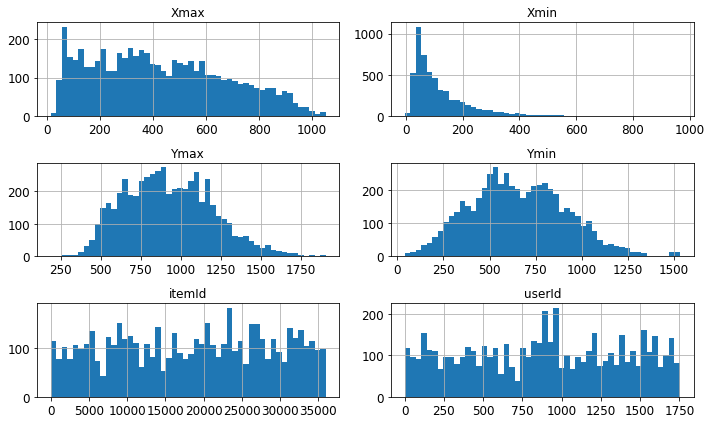

In [25]:
votes.hist(bins=50, figsize=(10,6))
save_fig("votes_histogram_plots")
plt.show()

Saving figure answers_histogram_plots


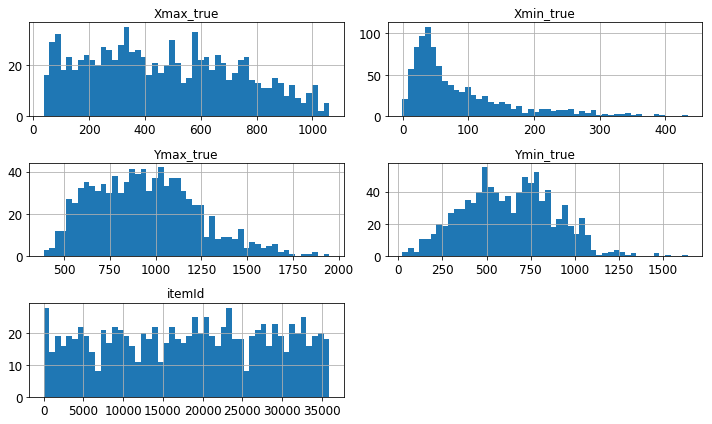

In [26]:
answers.hist(bins=50, figsize=(10,6))
save_fig("answers_histogram_plots")
plt.show()

Saving figure votes_hitemId_plots


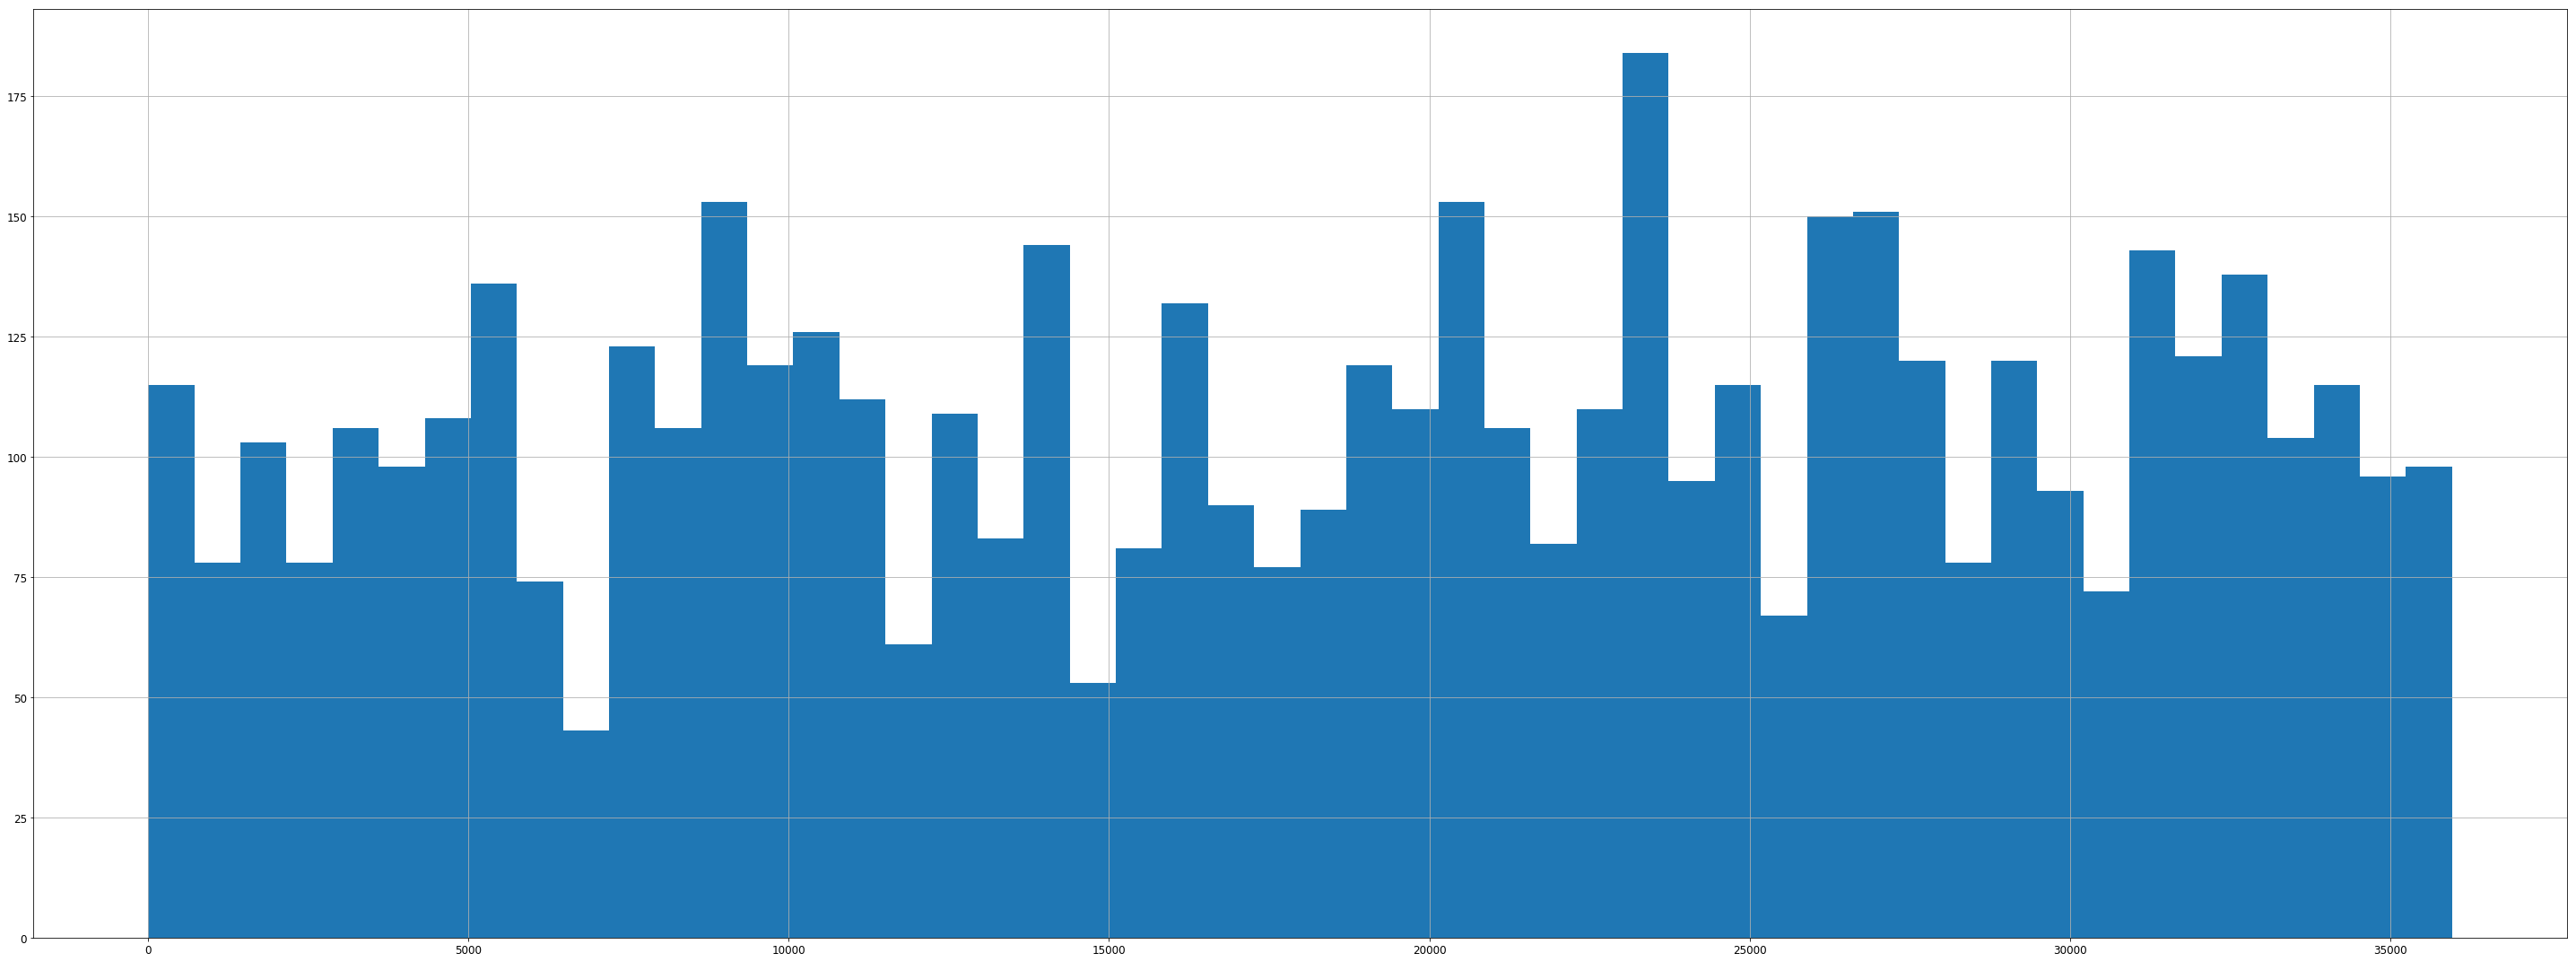

In [20]:
votes["itemId"].hist(bins=50, figsize=(40,15))
save_fig("votes_hitemId_plots")
plt.show()

Saving figure answers_hitemId_plots


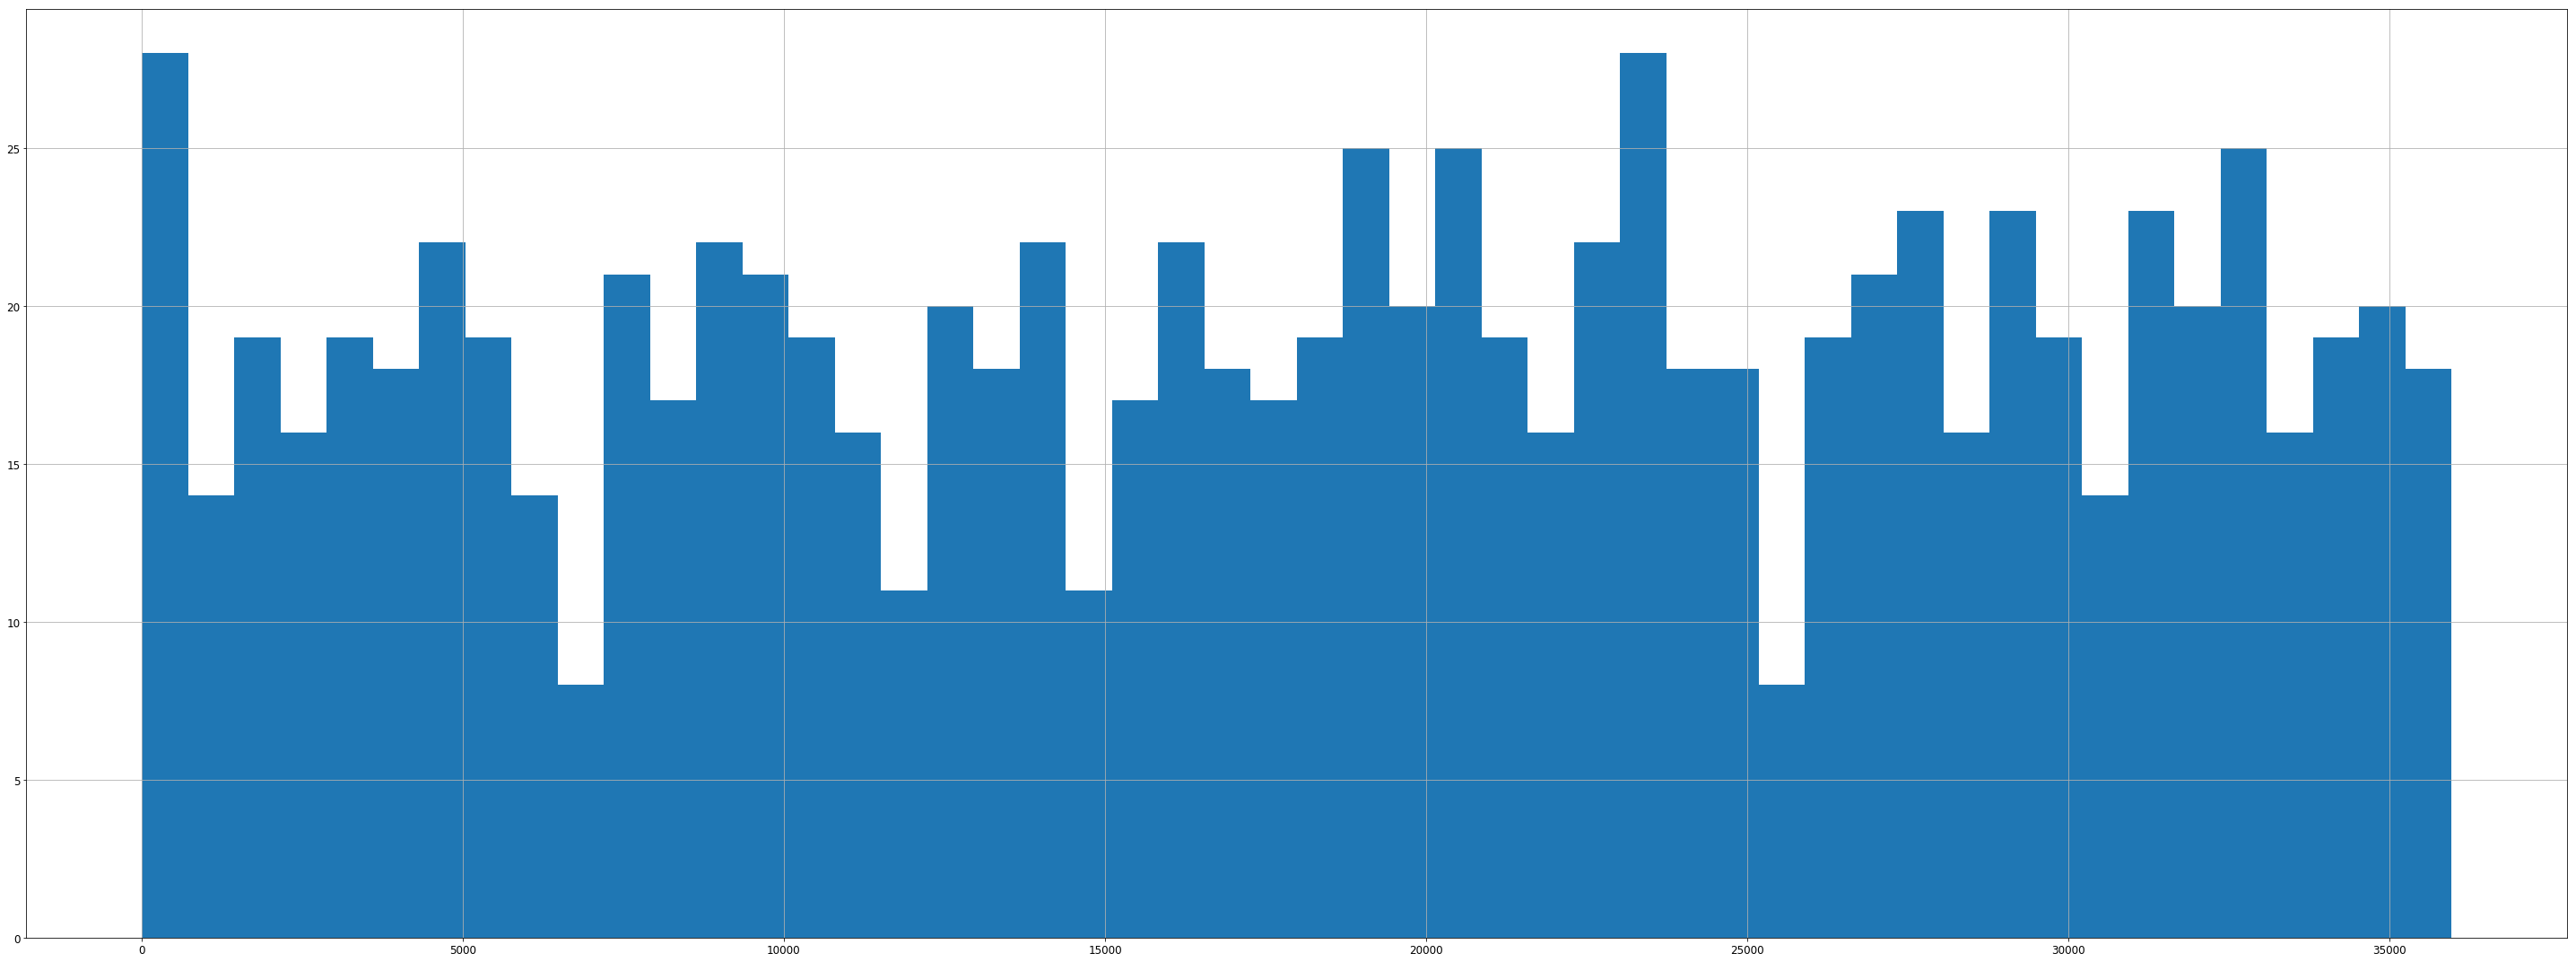

In [21]:
answers["itemId"].hist(bins=50, figsize=(40,15))
save_fig("answers_hitemId_plots")
plt.show()

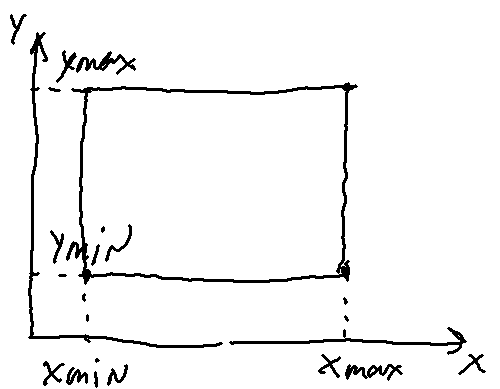

Saving figure votest_X_visualisation


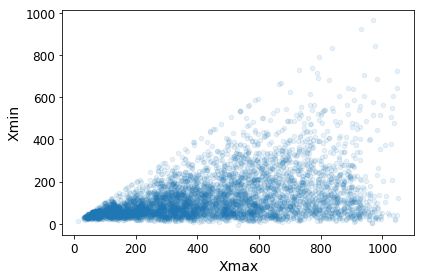

In [37]:
votes.plot(kind="scatter", x="Xmax", y="Xmin", alpha=0.1)
save_fig("votest_X_visualisation")

Saving figure votest_Y_visualisation


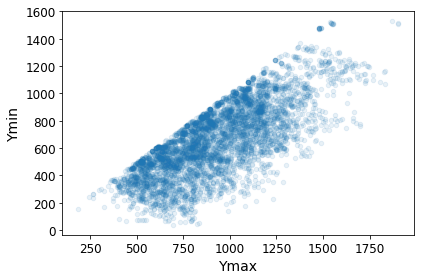

In [38]:
votes.plot(kind="scatter", x="Ymax", y="Ymin", alpha=0.1)
save_fig("votest_Y_visualisation")

Saving figure votest_XYmax_visualisation


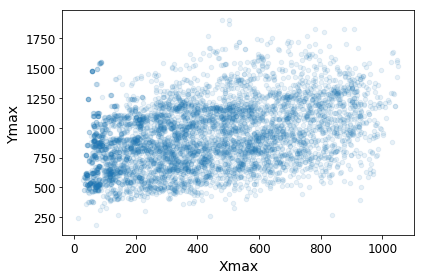

In [53]:
votes.plot(kind="scatter", x="Xmax", y="Ymax", alpha=0.1)
save_fig("votest_XYmax_visualisation")

Saving figure votest_XYmin_visualisation


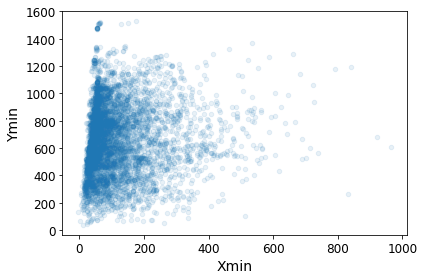

In [54]:
votes.plot(kind="scatter", x="Xmin", y="Ymin", alpha=0.1)
save_fig("votest_XYmin_visualisation")

минимальные значения все в основном вертятся вокруг начальной точки экрана, 
а вот максимальные распределены гораздо более вытянуто. Но это по прежнему не объясняет разницу в моджели распределения
Y и X

Saving figure votest_XYmin_Ymax_visualisation


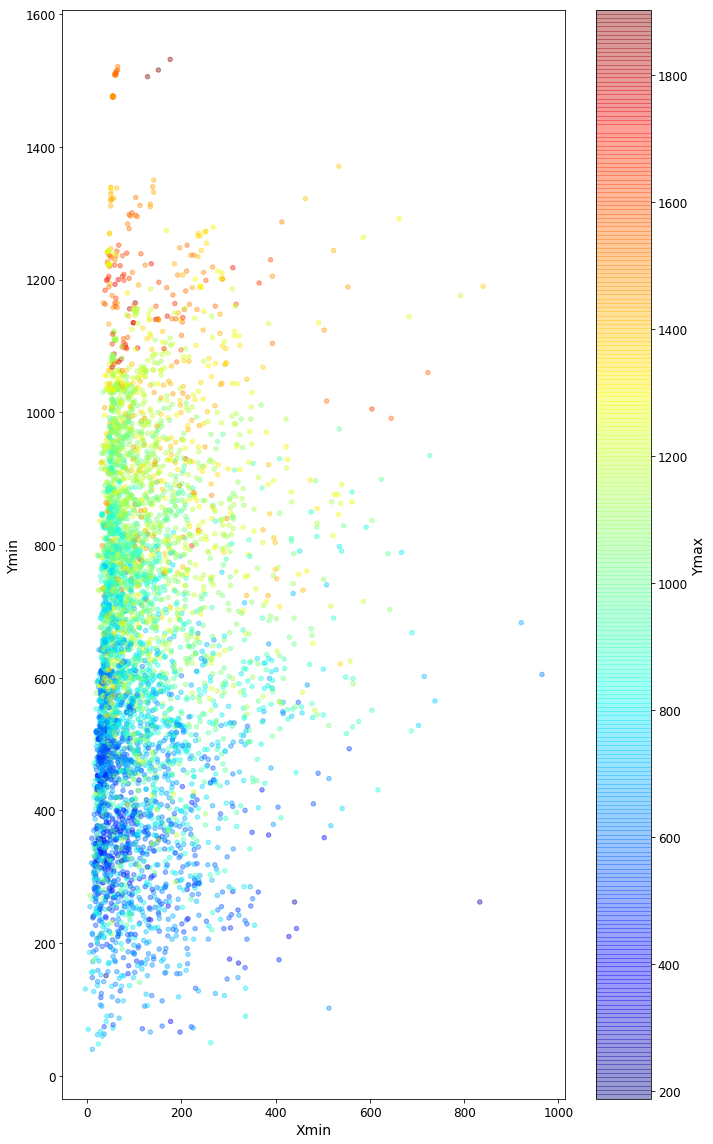

In [83]:
votes.plot(kind="scatter", x="Xmin", y="Ymin", alpha=0.4, figsize=(10,16),
    c="Ymax", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
save_fig("votest_XYmin_Ymax_visualisation")

Тут мы видим, чтопользователь может выделять как захватывая область снизу вверх, так и наоборот.
Уже неплохо то, что практически нет случаев, когда пользователь захватил весь экран

Saving figure votest_XYmin_Xmax_visualisation


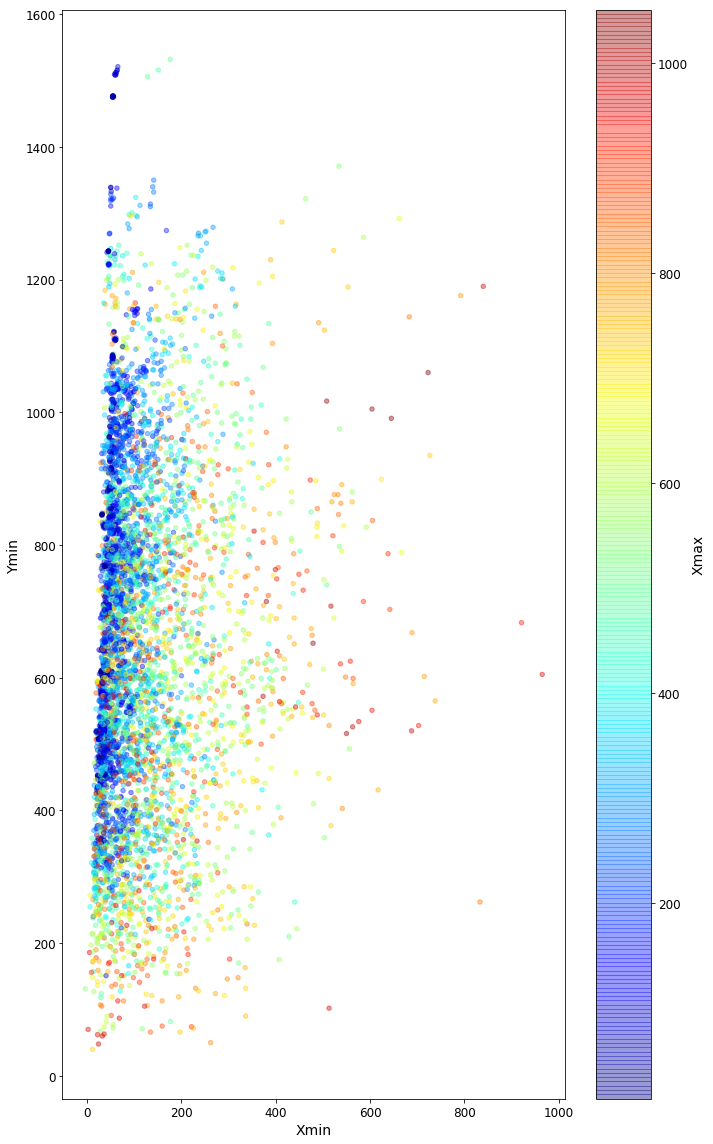

In [82]:
votes.plot(kind="scatter", x="Xmin", y="Ymin", alpha=0.4, figsize=(10,16),
    c="Xmax", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
save_fig("votest_XYmin_Xmax_visualisation")

А вот по Х совсем странное движение. Такое чувство что многих пользователей просили разметить какой-то 
узкий объект в левой части экрана

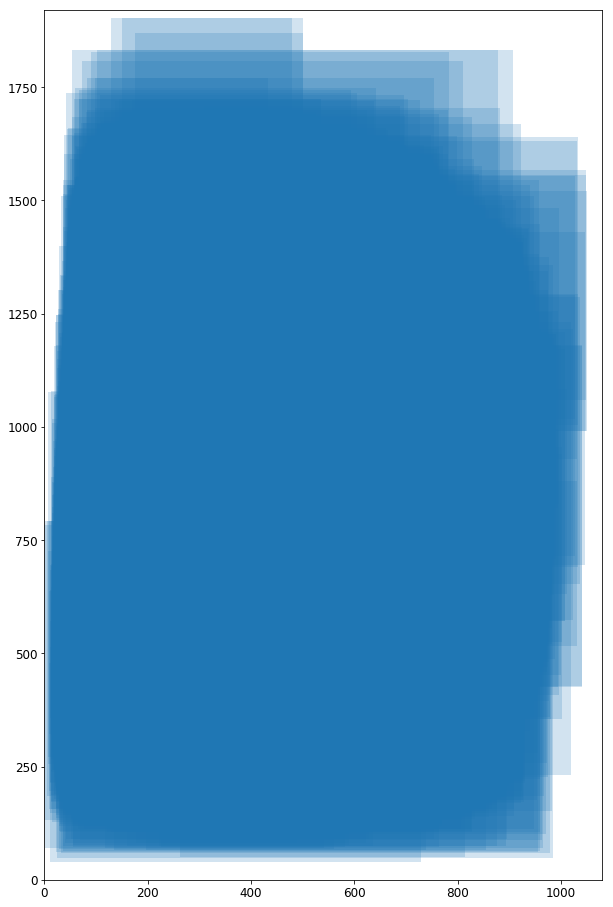

In [175]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0, 1080)
ax.set_ylim(0, 1920)
fig.set_figheight(16)
fig.set_figwidth(10)
for Xmin, Ymin, Xmax, Ymax in zip(votes["Xmin"], votes["Ymin"], votes["Xmax"], votes["Ymax"]):
    xy = float(Xmin), float(Ymin)
    width = float(Xmax - Xmin)
    height = float(Ymax - Ymin)
    rect = plt.Rectangle(xy, width, height, edgecolor='r', alpha=0.2, linewidth=0.0)
    ax.add_patch(rect)

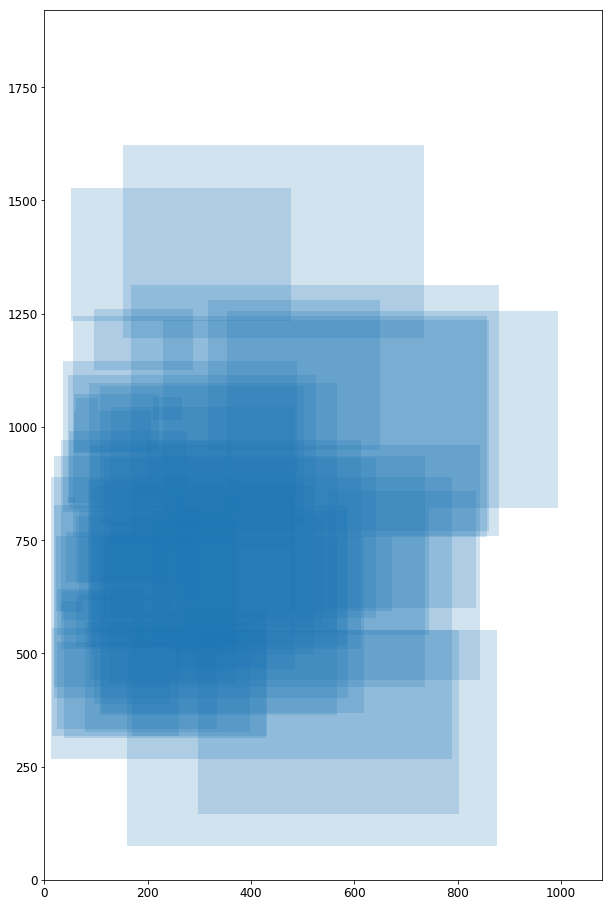

In [174]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0, 1080)
ax.set_ylim(0, 1920)
fig.set_figheight(16)
fig.set_figwidth(10)
for Xmin, Ymin, Xmax, Ymax in zip(votes["Xmin"][::100], votes["Ymin"][::100], votes["Xmax"][::100], votes["Ymax"][::100]):
    xy = float(Xmin), float(Ymin)
    width = float(Xmax - Xmin)
    height = float(Ymax - Ymin)
    rect = plt.Rectangle(xy, width, height, edgecolor='r', alpha=0.2, linewidth=0.0)
    ax.add_patch(rect)

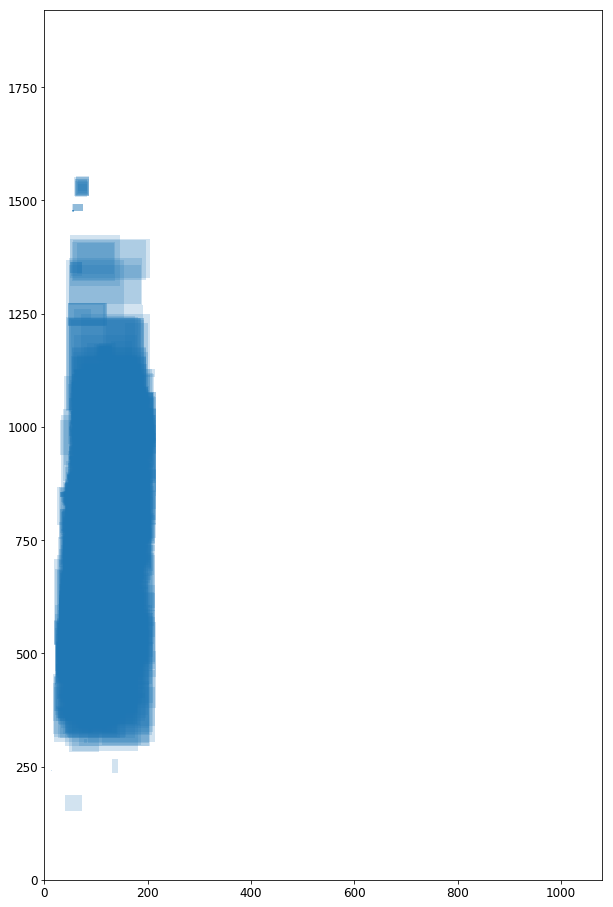

In [176]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0, 1080)
ax.set_ylim(0, 1920)
fig.set_figheight(16)
fig.set_figwidth(10)
count = 0
for Xmin, Ymin, Xmax, Ymax in zip(votes["Xmin"], votes["Ymin"], votes["Xmax"], votes["Ymax"]):    
    if Xmax <= 216:
        count += 1
        xy = float(Xmin), float(Ymin)
        width = float(Xmax - Xmin)
        height = float(Ymax - Ymin)
        rect = plt.Rectangle(xy, width, height, edgecolor='r', alpha=0.2, linewidth=0.0)
        ax.add_patch(rect)    

In [178]:
count * 100 / len(votes)

24.957841483979763

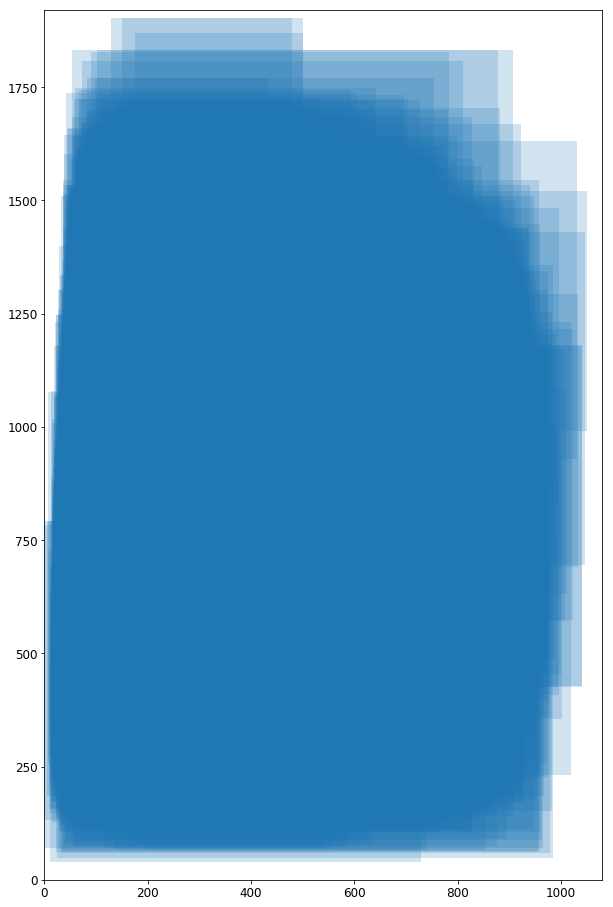

In [183]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0, 1080)
ax.set_ylim(0, 1920)
fig.set_figheight(16)
fig.set_figwidth(10)
count = 0
for Xmin, Ymin, Xmax, Ymax in zip(votes["Xmin"], votes["Ymin"], votes["Xmax"], votes["Ymax"]):    
    if Xmin <= 216:
        count += 1
        xy = float(Xmin), float(Ymin)
        width = float(Xmax - Xmin)
        height = float(Ymax - Ymin)
        rect = plt.Rectangle(xy, width, height, edgecolor='r', alpha=0.2, linewidth=0.0)
        ax.add_patch(rect) 

In [184]:
count * 100 / len(votes)

86.30316657298107

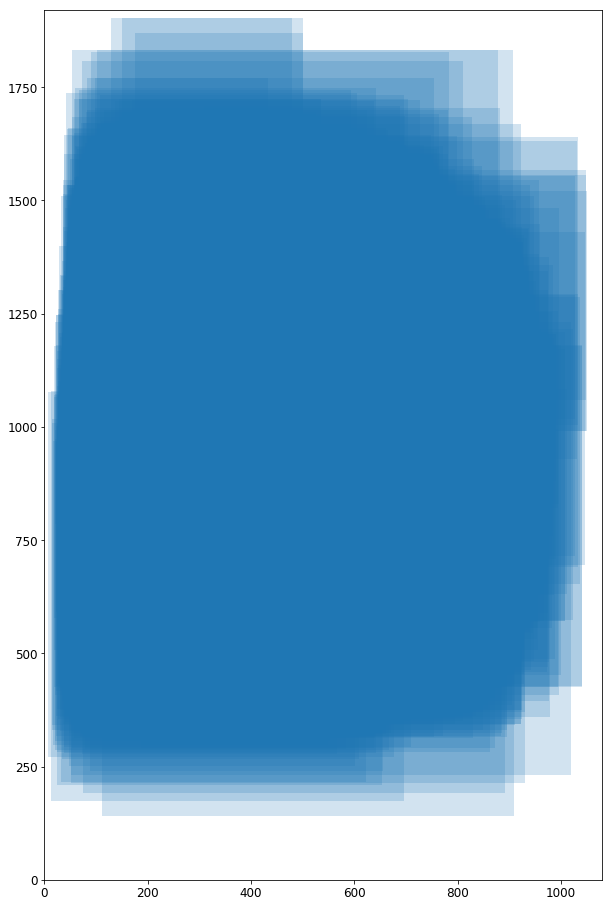

In [189]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0, 1080)
ax.set_ylim(0, 1920)
fig.set_figheight(16)
fig.set_figwidth(10)
count = 0
for Xmin, Ymin, Xmax, Ymax in zip(votes["Xmin"], votes["Ymin"], votes["Xmax"], votes["Ymax"]):    
    if Ymax >= 960:
        count += 1
        xy = float(Xmin), float(Ymin)
        width = float(Xmax - Xmin)
        height = float(Ymax - Ymin)
        rect = plt.Rectangle(xy, width, height, edgecolor='r', alpha=0.2, linewidth=0.0)
        ax.add_patch(rect)

In [190]:
count * 100 / len(votes)

43.245268877646616

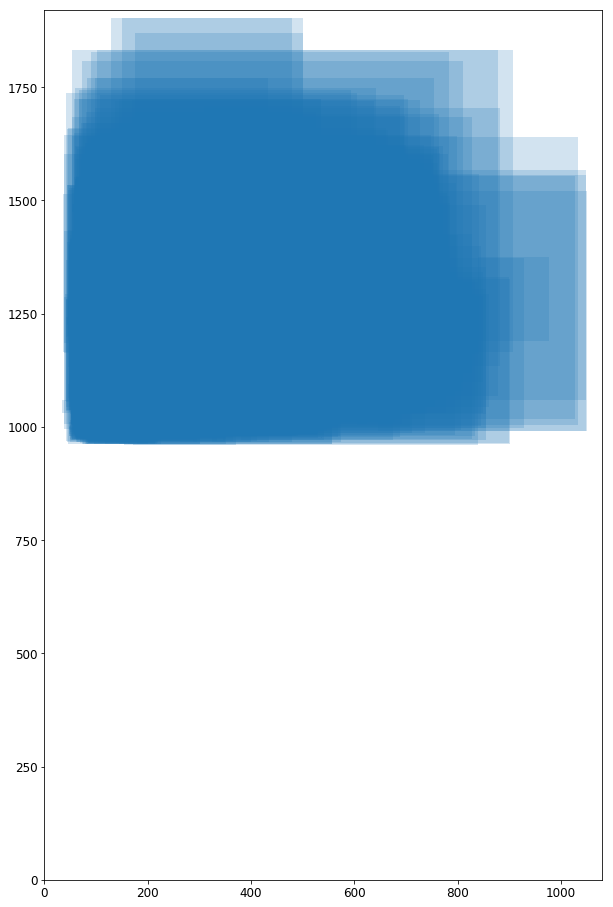

In [191]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0, 1080)
ax.set_ylim(0, 1920)
fig.set_figheight(16)
fig.set_figwidth(10)
count = 0
for Xmin, Ymin, Xmax, Ymax in zip(votes["Xmin"], votes["Ymin"], votes["Xmax"], votes["Ymax"]):    
    if Ymin >= 960:
        count += 1
        xy = float(Xmin), float(Ymin)
        width = float(Xmax - Xmin)
        height = float(Ymax - Ymin)
        rect = plt.Rectangle(xy, width, height, edgecolor='r', alpha=0.2, linewidth=0.0)
        ax.add_patch(rect)  

In [192]:
count * 100 / len(votes)

12.87240022484542

In [193]:
pearson = votes.corr()

In [220]:
pearson["userId"].sort_values(ascending=False)

userId    1.000000
Xmax     -0.009174
Ymax     -0.020202
Xmin     -0.021758
Ymin     -0.028054
itemId   -0.056528
Name: userId, dtype: float64

In [221]:
pearson["itemId"].sort_values(ascending=False)

itemId    1.000000
Xmin     -0.006567
Ymin     -0.009344
Xmax     -0.015997
Ymax     -0.024751
userId   -0.056528
Name: itemId, dtype: float64

In [222]:
pearson["Xmin"].sort_values(ascending=False)

Xmin      1.000000
Xmax      0.436868
Ymax      0.174405
Ymin      0.079259
itemId   -0.006567
userId   -0.021758
Name: Xmin, dtype: float64

In [224]:
pearson["Xmax"].sort_values(ascending=False)

Xmax      1.000000
Xmin      0.436868
Ymax      0.384217
userId   -0.009174
itemId   -0.015997
Ymin     -0.216119
Name: Xmax, dtype: float64

In [223]:
pearson["Ymin"].sort_values(ascending=False)

Ymin      1.000000
Ymax      0.740552
Xmin      0.079259
itemId   -0.009344
userId   -0.028054
Xmax     -0.216119
Name: Ymin, dtype: float64

In [225]:
pearson["Ymax"].sort_values(ascending=False)

Ymax      1.000000
Ymin      0.740552
Xmax      0.384217
Xmin      0.174405
userId   -0.020202
itemId   -0.024751
Name: Ymax, dtype: float64

Saving figure person_correlation_plot


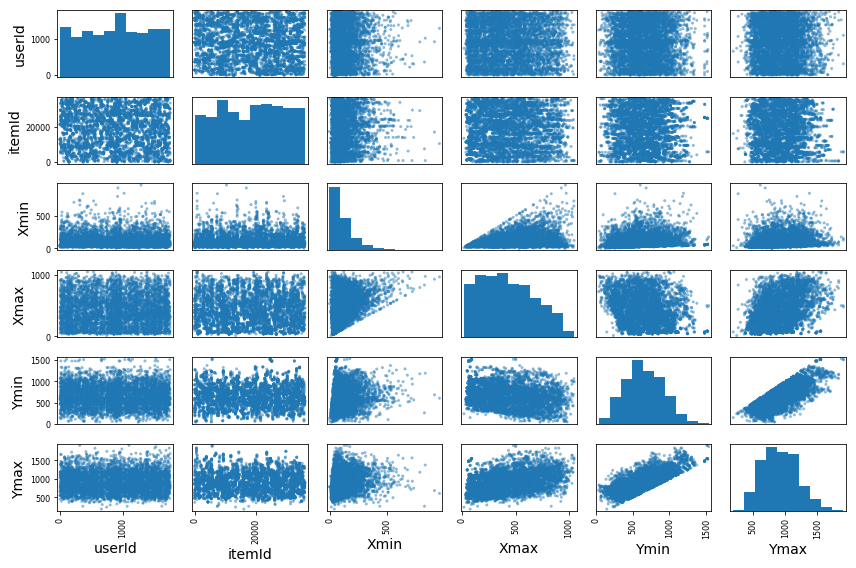

In [198]:
from pandas.plotting import scatter_matrix

attributes = ["userId", "itemId", "Xmin", "Xmax", "Ymin",
              "Ymax"]
scatter_matrix(votes[attributes], figsize=(12, 8))
save_fig("person_correlation_plot")

Saving figure Ymax_Ymin_scatterplot


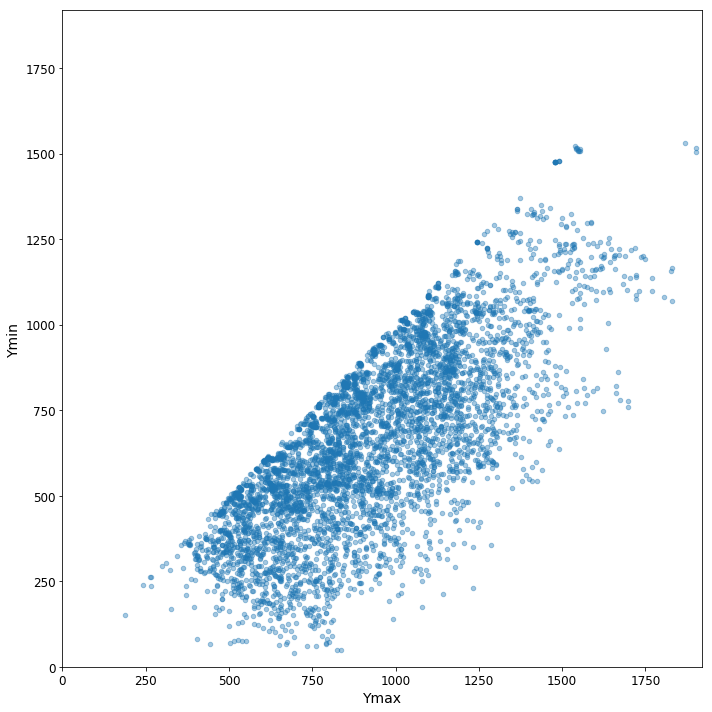

In [208]:
votes.plot(kind="scatter", x="Ymax", y="Ymin",
             alpha=0.4, figsize=(10, 10))
plt.axis([0, 1920, 0, 1920])
save_fig("Ymax_Ymin_scatterplot")

Saving figure Xmax_Xmin_scatterplot


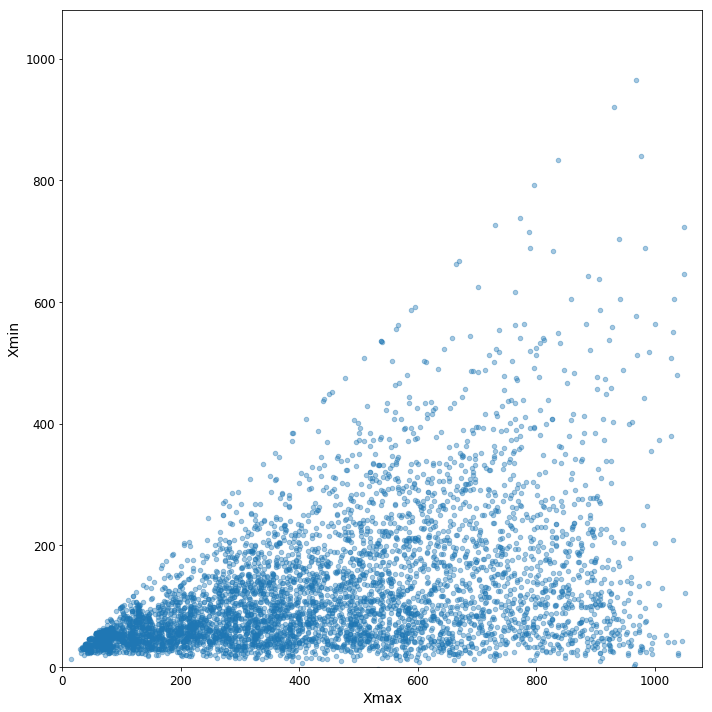

In [226]:
votes.plot(kind="scatter", x="Xmax", y="Xmin",
             alpha=0.4, figsize=(10, 10))
plt.axis([0, 1080, 0, 1080])
save_fig("Xmax_Xmin_scatterplot")

Saving figure Xmax_Ymin_scatterplot


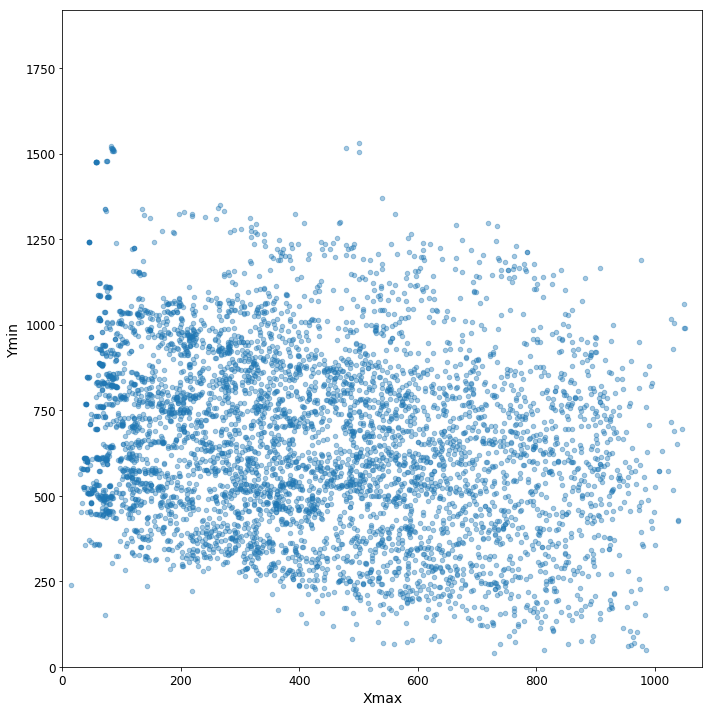

In [227]:
votes.plot(kind="scatter", x="Xmax", y="Ymin",
             alpha=0.4, figsize=(10, 10))
plt.axis([0, 1080, 0, 1920])
save_fig("Xmax_Ymin_scatterplot")

Saving figure Xmax_userid_scatterplot


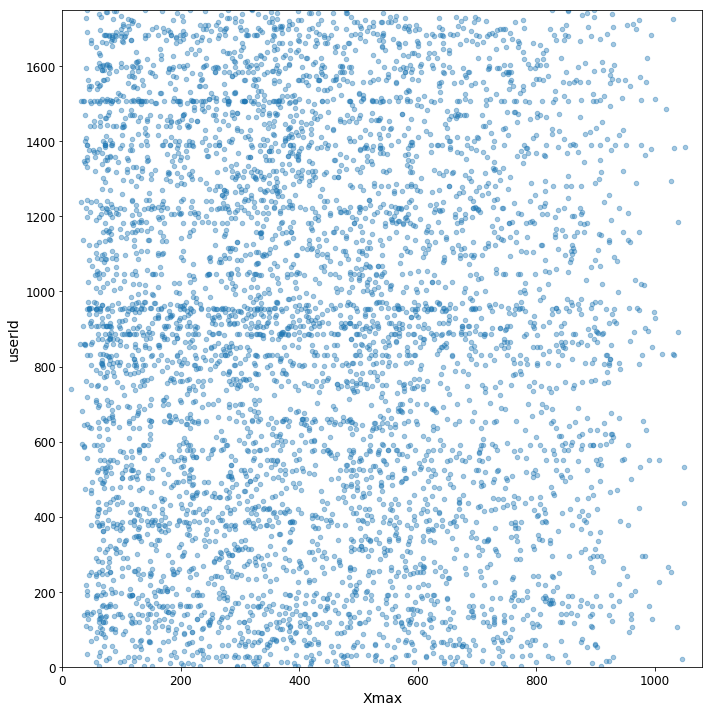

In [214]:
votes.plot(kind="scatter", x="Xmax", y="userId",
             alpha=0.4, figsize=(10, 10))
plt.axis([0, 1080, 0, 1750])
save_fig("Xmax_userid_scatterplot")

Saving figure Xmax_itemid_scatterplot


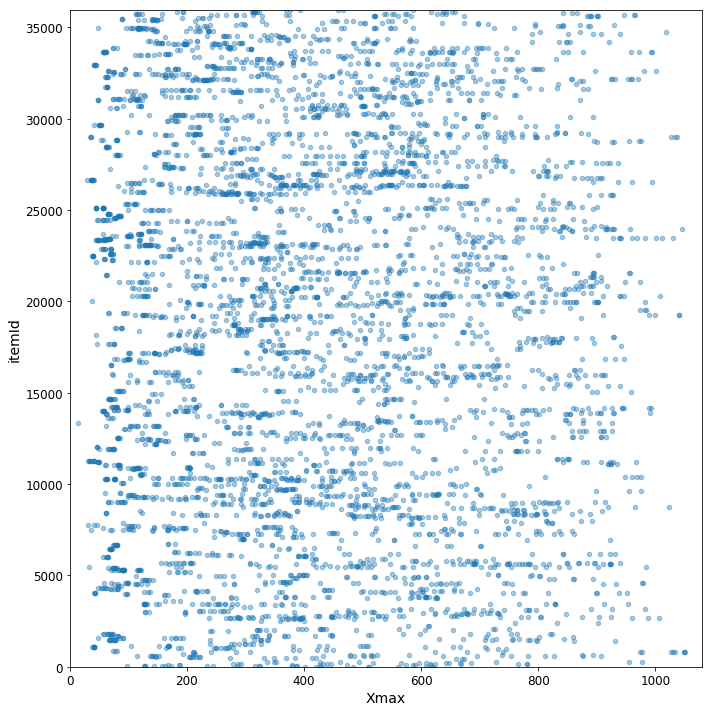

In [219]:
votes.plot(kind="scatter", x="Xmax", y="itemId",
             alpha=0.4, figsize=(10, 10))
plt.axis([0, 1080, 0, 35962])
save_fig("Xmax_itemid_scatterplot")

In [230]:
votes['Xmin_per_Xmax'] = votes['Xmin']/votes['Xmax']
votes['Xmin_per_Ymax'] = votes['Xmin']/votes['Ymax']
votes['Xmin_per_Ymin'] = votes['Xmin']/votes['Ymin']
votes['Xmax_per_Ymax'] = votes['Xmax']/votes['Ymax']
votes['Xmax_per_Ymin'] = votes['Xmax']/votes['Ymin']
votes['Ymax_per_Ymin'] = votes['Ymax']/votes['Ymin']

In [231]:
votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5337 entries, 0 to 5336
Data columns (total 12 columns):
userId           5337 non-null int64
itemId           5337 non-null int64
Xmin             5337 non-null int64
Ymin             5337 non-null int64
Xmax             5337 non-null int64
Ymax             5337 non-null int64
Xmin_per_Xmax    5337 non-null float64
Xmin_per_Ymax    5337 non-null float64
Xmin_per_Ymin    5337 non-null float64
Xmax_per_Ymax    5337 non-null float64
Xmax_per_Ymin    5337 non-null float64
Ymax_per_Ymin    5337 non-null float64
dtypes: float64(6), int64(6)
memory usage: 500.4 KB


Saving figure person_correlation_sintethic_plot


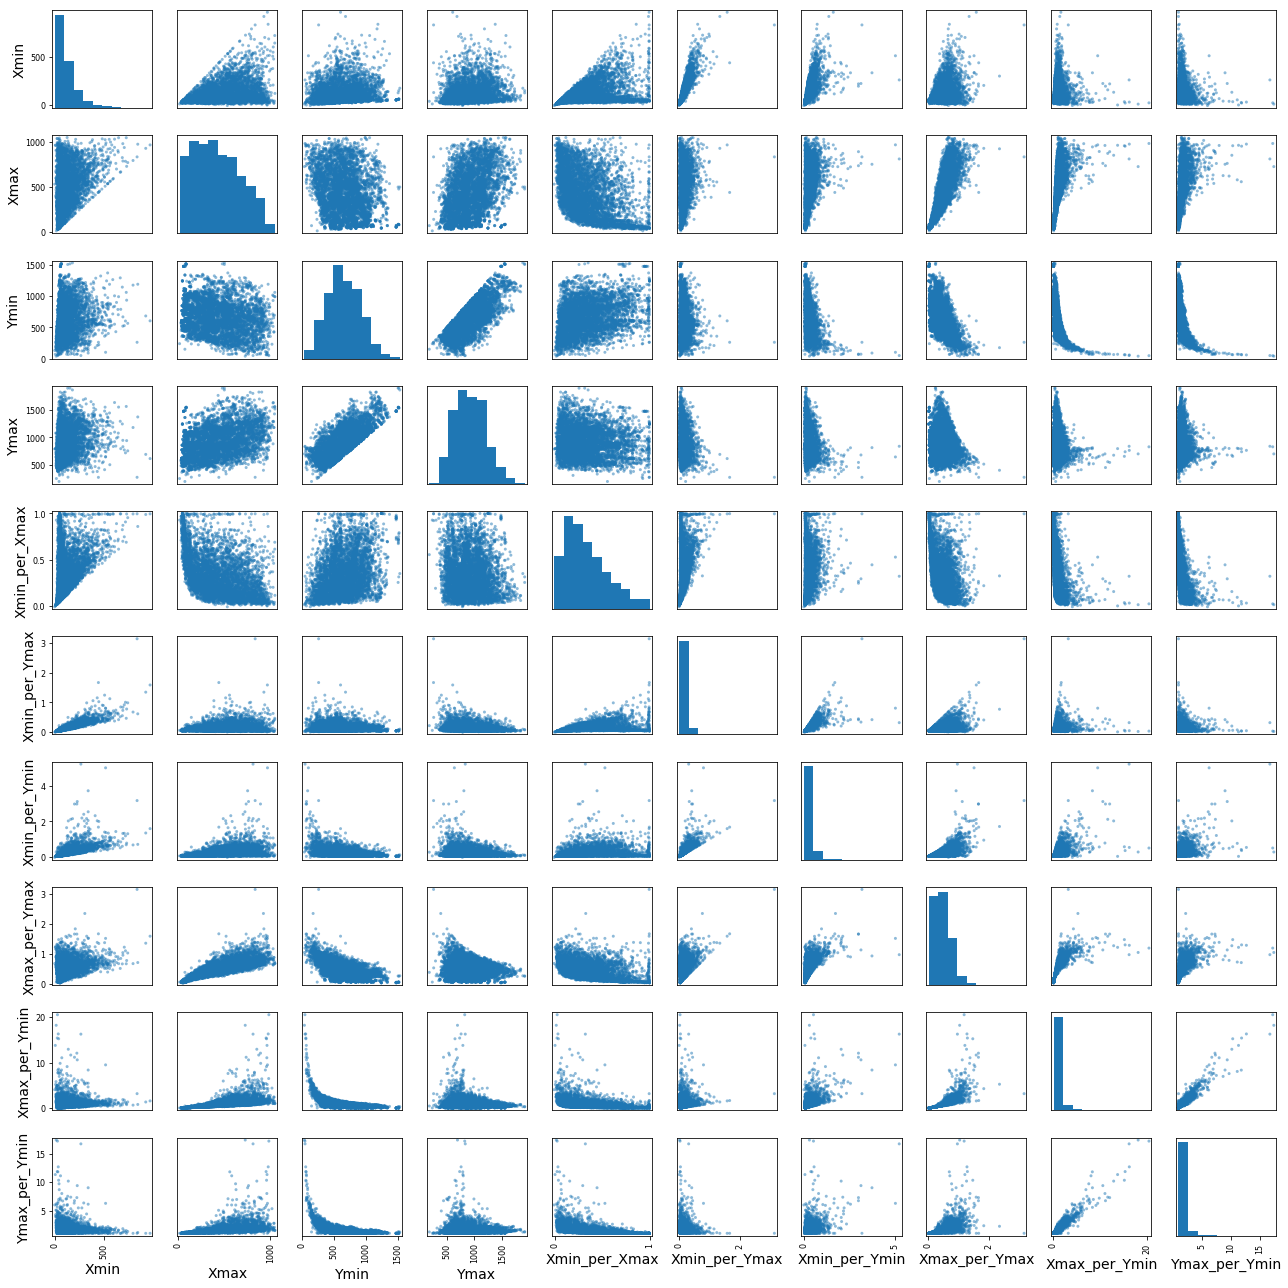

In [234]:
attributes = ["Xmin", "Xmax", "Ymin",
              "Ymax","Xmin_per_Xmax", "Xmin_per_Ymax", "Xmin_per_Ymin",
             "Xmax_per_Ymax", "Xmax_per_Ymin", "Ymax_per_Ymin"]
scatter_matrix(votes[attributes], figsize=(18, 18))
save_fig("person_correlation_sintethic_plot")